In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
from matplotlib.colors import LogNorm
#import scipy.io as so

mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=12)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=12)
mpl.rc('font', size=12)
%matplotlib inline

In [2]:
chlToN=1.6
indj,indi=places.PLACES['Sentry Shoal']['NEMO grid ji']
lon,lat=places.PLACES['Sentry Shoal']['lon lat']
indk=0

In [3]:
datelims=(dt.datetime(1900,1,1),dt.datetime(2100,1,1))
start_date=datelims[0]
end_date=datelims[1]
#hblat=49.34
#hblon=-123.72
hbz=1.0

In [4]:
dfN = pd.read_excel('/ocean/shared/SalishSeaCastData/SOGDC/SentryShoal/2015_SUNA0588_TempSalNitrate.xlsx',
                 sheet_name = 'SS - 2015 - SUNA0588_BATCH_pro_',skiprows=8,header=None,
                   names=['header','date','time','Temp','Sal','origN','reprocN','linear','const','RMSE','a','b'],
                  dtype={0:str,1:str,2:str,3:float,4:float,5:float,6:float,7:float,8:float,9:float,10:float,11:float})
fP1 = pd.read_excel('/ocean/shared/SalishSeaCastData/SOGDC/SentryShoal/ctd_SBE37_2015_SentryShoal.xlsx',
                 sheet_name = '201504',skiprows=8,header=None,
                   names=['datetime','Temp','Cond','Sal'],
                  dtype={0:str,1:float,2:float,3:float})
fP2 = pd.read_excel('/ocean/shared/SalishSeaCastData/SOGDC/SentryShoal/ctd_SBE37_2015_SentryShoal.xlsx',
                 sheet_name = '201506',skiprows=8,header=None,
                   names=['datetime','Temp','Cond','Sal'],
                  dtype={0:str,1:float,2:float,3:float})
fP3 = pd.read_excel('/ocean/shared/SalishSeaCastData/SOGDC/SentryShoal/ctd_SBE37_2015_SentryShoal.xlsx',
                 sheet_name = '201508',skiprows=8,header=None,
                   names=['datetime','Temp','Cond','Sal'],
                  dtype={0:str,1:float,2:float,3:float})

In [5]:
dfP=pd.concat([fP1,fP2,fP3],ignore_index=True)
print(dfP['datetime'].values[0])
print(dfN['date'].values[0],dfN['time'].values[0])

2015-04-19 00:27:48
2015-04-18 00:00:00 08:00:21.240000


In [6]:
dfN['date'].values[0]+'T'+dfN['time'].values[0]

'2015-04-18 00:00:00T08:00:21.240000'

In [7]:
dts=[dt.datetime.strptime(ii+'T'+jj[0:8],'%Y-%m-%d 00:00:00T%H:%M:%S')+dt.timedelta() for ii,jj in zip(dfN['date'].values,dfN['time'].values)]
dfN['dtUTC']=dts

In [8]:
dts=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') for ii in dfP['datetime'].values]
dfP['dtUTC']=dts

In [9]:
dfN.head()

,header,date,time,Temp,Sal,origN,reprocN,linear,const,RMSE,a,b,dtUTC
0,SATNPRO0588,2015-04-18 00:00:00,08:00:21.240000,11.48,26.57,3.59,-48.92,1.31298,-0.005384,0.010289,0.035316,0.049461,2015-04-18 08:00:21
1,SATNPRO0588,2015-04-18 00:00:00,08:00:23.072000,11.48,26.57,3.33,-48.85,1.31148,-0.005379,0.010302,0.035046,0.048483,2015-04-18 08:00:23
2,SATNPRO0588,2015-04-18 00:00:00,08:00:24.904000,11.48,26.57,3.59,-48.84,1.31143,-0.005379,0.010314,0.034891,0.047635,2015-04-18 08:00:24
3,SATNPRO0588,2015-04-18 00:00:00,08:30:21.167000,11.48,26.57,3.75,-48.95,1.32731,-0.005431,0.010324,0.038455,0.052193,2015-04-18 08:30:21
4,SATNPRO0588,2015-04-18 00:00:00,08:30:23,11.48,26.57,3.84,-48.87,1.32486,-0.005422,0.010327,0.038241,0.051124,2015-04-18 08:30:23


In [10]:
dfP.head()

,datetime,Temp,Cond,Sal,dtUTC
0,2015-04-19 00:27:48,11.4796,3.081419,26.5698,2015-04-19 00:27:48
1,2015-04-19 00:57:48,11.7958,3.093040,26.4544,2015-04-19 00:57:48
2,2015-04-19 01:27:48,11.1284,3.070094,26.7146,2015-04-19 01:27:48
3,2015-04-19 01:57:48,11.8268,3.113302,26.6237,2015-04-19 01:57:48
4,2015-04-19 02:27:48,11.6410,3.124861,26.8667,2015-04-19 02:27:48


In [11]:
p=gsw.p_from_z(1.0,lat)
dfP['SA']=[gsw.SA_from_SP(ii,p,lon,lat) for ii in dfP['Sal']]
dfP['CT']=[gsw.CT_from_t(iisa,iit,p) for iisa, iit in zip(dfP['SA'],dfP['Temp'])]

In [12]:
# load extracted Halibut Bank model results
dirs=('hindcast2015','hindcast2015P')
#dirnames=('spring2015_NewSink','spring2015_slowPP','spring2015_KhT','spring2015_diatHS')
varNameDict={'Halibut Bank':'HalibutBank','Sentry Shoal':'SentryShoal', 'S3':'S3', 'Central node':'CentralNode', 'Central SJDF':'CentralSJDF'}
plist=('Sentry Shoal',)
with open('/ocean/eolson/MEOPAR/analysis-elise/notebooks/bioTuning/spathsMaster.txt') as f:
    spaths = dict(x.strip().split() for x in f)
ff=dict()
for idir in dirs:
    ff[idir]=dict()
    for pl in plist:
        print(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
        ff[idir][pl]=nc.Dataset(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')

/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_SentryShoal.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015P_SentryShoal.nc


In [13]:
torig=dt.datetime.strptime(ff[idir][plist[0]].variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S')
dtMod=np.array([torig + dt.timedelta(seconds=ii) for ii in ff[idir][plist[0]].variables['time_centered'][:]])

In [14]:
f=ff['hindcast2015']['Sentry Shoal']
fp=ff['hindcast2015P']['Sentry Shoal']

In [15]:
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc') as mesh:
    deptht=mesh.variables['gdept_1d'][0,:]

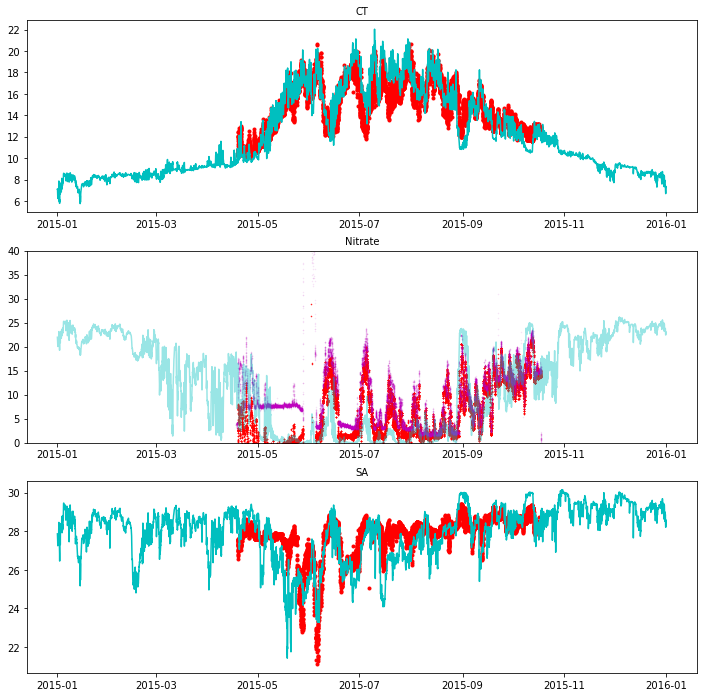

In [16]:
fig,ax=plt.subplots(3,1,figsize=(12,12))

ax[0].plot(dfP['dtUTC'],dfP['CT'],'r.')
##var=np.sum(fp.variables['votemper'][:,:2,0,0]*fp.variables['e3t'][:,:2,0,0],1)/np.sum(fp.variables['e3t'][:,:2,0,0],1)
var=fp.variables['votemper'][:,0,0,0]
ax[0].plot(dtMod,var,'c-')
ax[0].set_title('CT')

ax[1].plot(dfN['dtUTC'],dfN['reprocN'],'r.',markersize=1)
ax[1].plot(dfN['dtUTC'],dfN['origN'],'m.',markersize=1,alpha=.1)
#var=chlToN*np.sum((f.variables['diatoms'][:,:2,0,0]+f.variables['ciliates'][:,:2,0,0]+f.variables['flagellates'][:,:2,0,0])*f.variables['e3t'][:,:2,0,0],1)/np.sum(f.variables['e3t'][:,:2,0,0],1)
var=f.variables['nitrate'][:,0,0,0]
ax[1].plot(dtMod,var,'c-',alpha=.4)
ax[1].set_ylim(0,40)
ax[1].set_title('Nitrate')

ax[2].plot(dfP['dtUTC'],dfP['SA'],'r.')
#var=np.sum(f.variables['Fraser_tracer'][:,:2,0,0]*f.variables['e3t'][:,:2,0,0],1)/np.sum(f.variables['e3t'][:,:2,0,0],1)
var=fp.variables['vosaline'][:,0,0,0]
ax[2].plot(dtMod,var,'c-')
ax[2].set_title('SA')

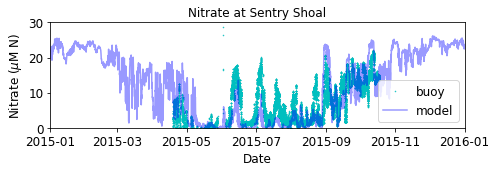

In [35]:
fig,ax=plt.subplots(1,1,figsize=(7,2.5))

b,=ax.plot(dfN['dtUTC'],dfN['reprocN'],'c.',markersize=1,label='buoy')
#ax.plot(dfN['dtUTC'],dfN['origN'],'m.',markersize=1,alpha=.1)
#var=chlToN*np.sum((f.variables['diatoms'][:,:2,0,0]+f.variables['ciliates'][:,:2,0,0]+f.variables['flagellates'][:,:2,0,0])*f.variables['e3t'][:,:2,0,0],1)/np.sum(f.variables['e3t'][:,:2,0,0],1)
var=f.variables['nitrate'][:,0,0,0]
m,=ax.plot(dtMod,var,'b-',alpha=.4,label='model')
ax.set_ylim(0,30)
ax.set_xlim((dt.datetime(2015,1,1),dt.datetime(2016,1,1)))
ax.legend()
ax.set_ylabel('Nitrate ($\mu$M N)')
ax.set_xlabel('Date')
ax.set_title('Nitrate at Sentry Shoal')
fig.tight_layout()
fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsEval/SSNitrage.eps',dpi=400,transparent=True)

In [ ]:
fid={'Bio':ff['hindcast2015']['Sentry Shoal'],'Phys':ff['hindcast2015P']['Sentry Shoal']}
filemap={'nitrate':'Bio','votemper':'Phys','vosaline':'Phys'}
ftypes=list(set(filemap.values()))
# reverse filemap dict
filemap_r=dict()
for ift in ftypes:
    filemap_r[ift]=list()
for ikey in filemap:
    filemap_r[filemap[ikey]].append(ikey)

# set up columns to accept model values
for ivar in filemap.keys():
    dfN['mod_'+ivar]=np.full(len(dfN),np.nan)

for ind, row in dfN.iterrows():
    for ift in ftypes:
        # find time index
        indh=et._getTimeInd_bin(row['dtUTC'],fid[ift],torig)
        # assign values for each var assoc with ift
        if not np.isnan(indk):
            for ivar in filemap_r[ift]:
                dfN.loc[ind,['mod_'+ivar]]=fid[ift].variables[ivar][indh,indk,0,0]

In [ ]:
fid={'Bio':ff['hindcast2015']['Sentry Shoal'],'Phys':ff['hindcast2015P']['Sentry Shoal']}
filemap={'nitrate':'Bio','votemper':'Phys','vosaline':'Phys'}
ftypes=list(set(filemap.values()))
# reverse filemap dict
filemap_r=dict()
for ift in ftypes:
    filemap_r[ift]=list()
for ikey in filemap:
    filemap_r[filemap[ikey]].append(ikey)

# set up columns to accept model values
for ivar in filemap.keys():
    dfP['mod_'+ivar]=np.full(len(dfP),np.nan)

for ind, row in dfP.iterrows():
    for ift in ftypes:
        # find time index
        indh=et._getTimeInd_bin(row['dtUTC'],fid[ift],torig)
        # assign values for each var assoc with ift
        if not np.isnan(indk):
            for ivar in filemap_r[ift]:
                dfP.loc[ind,['mod_'+ivar]]=fid[ift].variables[ivar][indh,indk,0,0]

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ii=(~np.isnan(dfN['reprocN']))&(~np.isnan(dfN['mod_nitrate']))&(dfN['reprocN']>=0)&(dfN['reprocN']<36)
counts, xedges, yedges, m1=ax.hist2d(dfN.loc[ii,['reprocN']].values.flatten(),
                                      dfN.loc[ii,['mod_nitrate']].values.flatten(),bins=25*2,norm=LogNorm())

ax.plot((0,35),(0,35),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count')
ax.set_xlim(0,35)
ax.set_ylim(0,35)

ax.set_ylabel('Modeled',fontsize=12)
ax.set_xlabel('Observed',fontsize=12)
ax.set_title('Nitrate')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ii=(~np.isnan(dfP['CT']))&(~np.isnan(dfP['mod_votemper']))
counts, xedges, yedges, m1=ax.hist2d(dfP.loc[ii,['Temp']].values.flatten(),
                                      dfP.loc[ii,['mod_votemper']].values.flatten(),bins=25*2,norm=LogNorm())

ax.plot((10,22),(10,22),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count')
#ax.set_xlim(-1,2)
#ax.set_ylim(-1,2)

ax.set_ylabel('Modeled',fontsize=12)
ax.set_xlabel('Observed',fontsize=12)
ax.set_title('CT')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ii=(~np.isnan(dfP['SA']))&(~np.isnan(dfP['mod_vosaline']))
counts, xedges, yedges, m1=ax.hist2d(dfP.loc[ii,['SA']].values.flatten(),
                                      dfP.loc[ii,['mod_vosaline']].values.flatten(),bins=25*2,norm=LogNorm())

ax.plot((22,30),(22,30),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count')
#ax.set_xlim(-1,2)
#ax.set_ylim(-1,2)

ax.set_ylabel('Modeled',fontsize=12)
ax.set_xlabel('Observed',fontsize=12)
ax.set_title('Turbidity')